In [1]:
# import from skimage
from skimage.color import rgb2gray
from skimage.filters import sobel, sobel_h, sobel_v, prewitt, roberts, gaussian
from skimage.feature import canny
import skimage.io as io
import cv2 as cv

from scipy.spatial import distance as dist

# import from matplotlib
import matplotlib.pyplot as plt

# import from numpy
import numpy as np

# import utils
from utils.commonfunctions import *


In [2]:
# img = io.imread("datasets/dataset_module1/01.jpg")

# read image 1.jpg
img = cv.imread('datasets/grade_sheet/6.jpg',0)
# colored_img = cv.imread('datasets/dataset_module1/01.jpg')
# img = cv.imread('datasets/dataset_module1/11.jpg',0)

# convert to greyscale
grey_scale = img

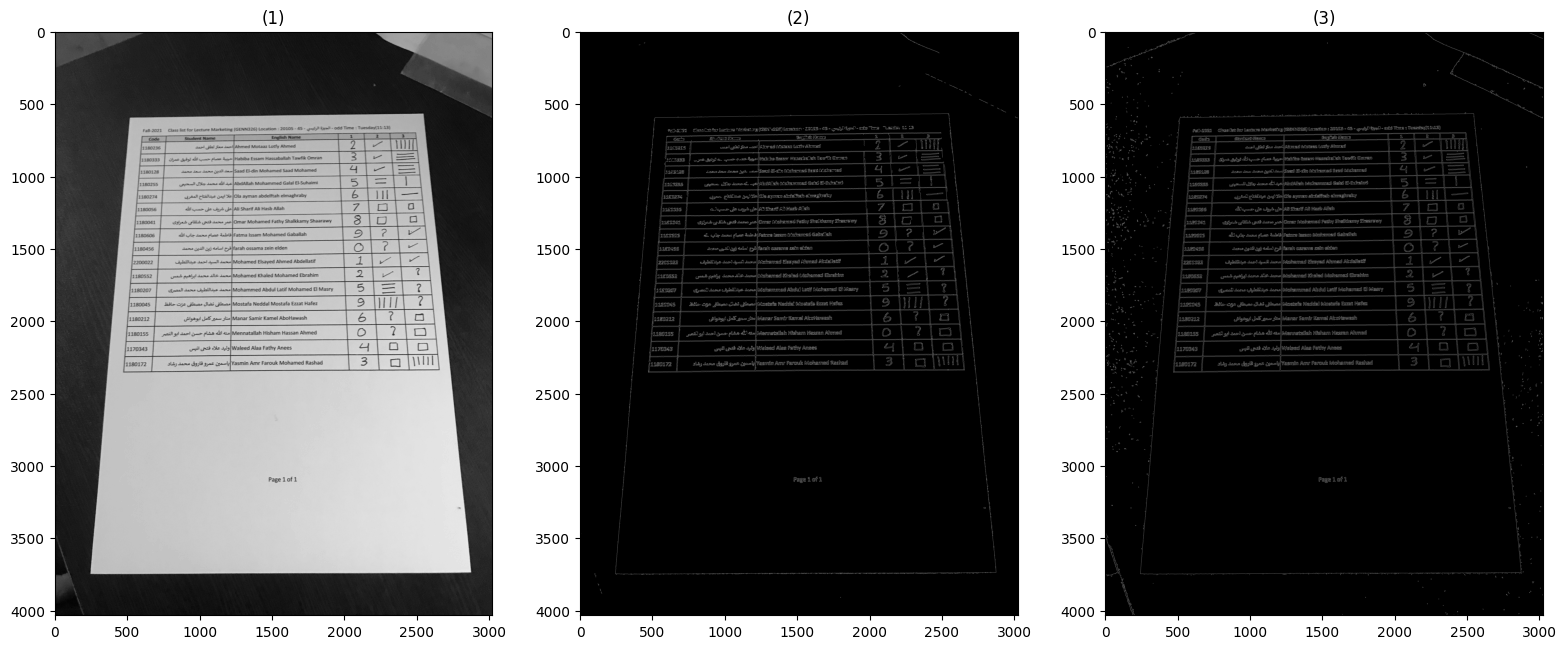

In [3]:
# use canny to detect edges
cannyEdges = cannyEdge(grey_scale)

# TODO: reomve print
show_images([grey_scale,cannyEdges,canny(grey_scale,sigma = 1)])

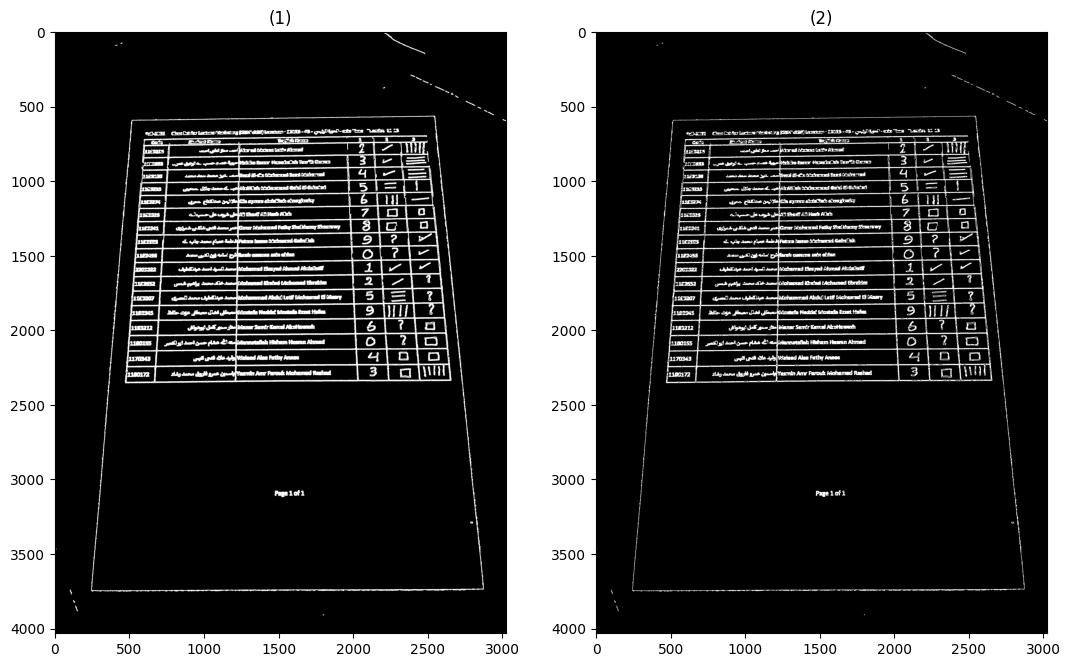

In [4]:
# Apply closing
# closing_kernel = np.ones((3,3))
# closing_img = closing(cannyEdges,closing_kernel)

dilate_kernel = np.ones((5,5))
erosion_kernel = np.ones((3,3))

dilated_img = dilate(cannyEdges,dilate_kernel)

closed_img = erode(dilated_img,erosion_kernel)

show_images([dilated_img,closed_img])

7351095.5
3238704.5


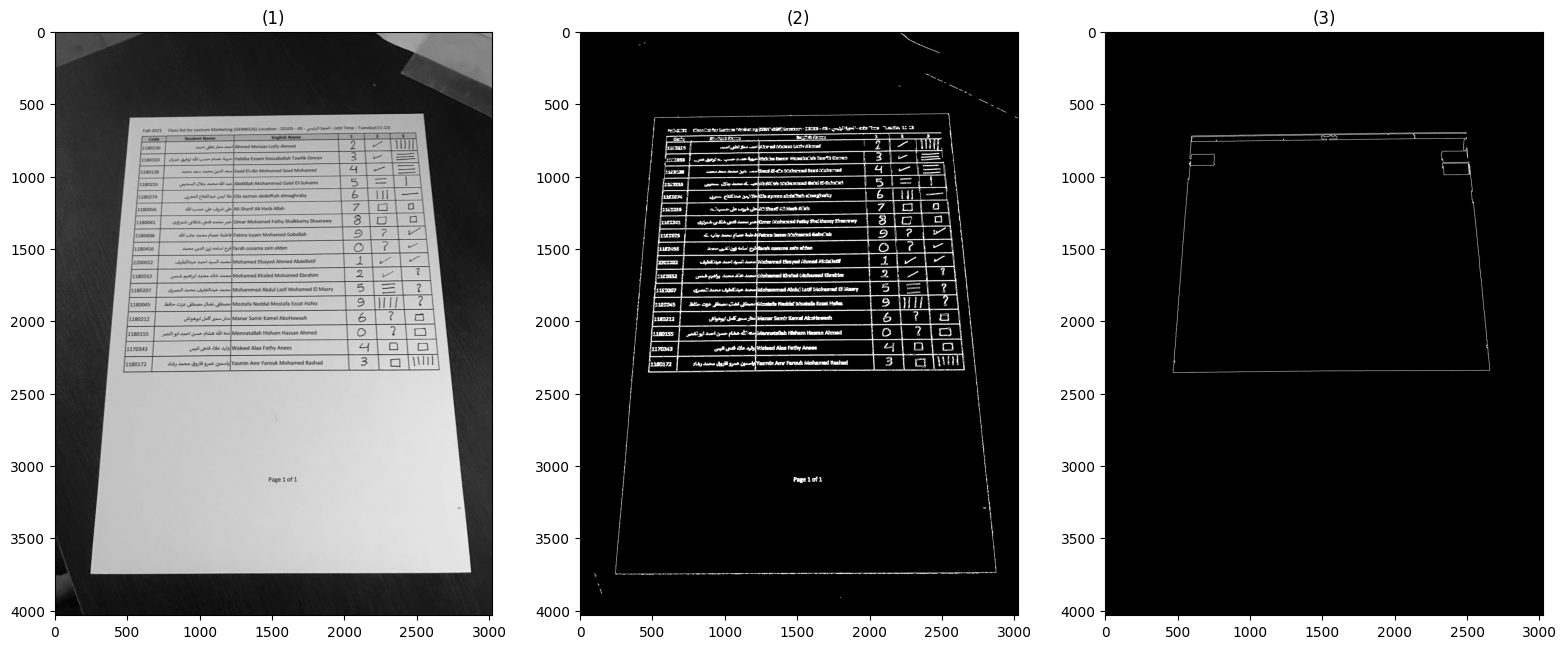

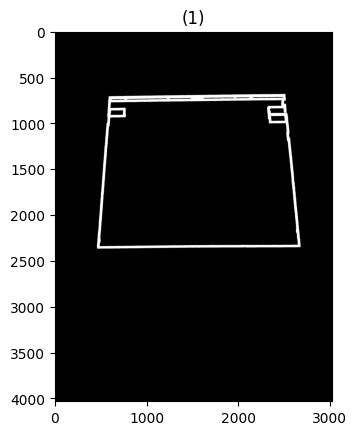

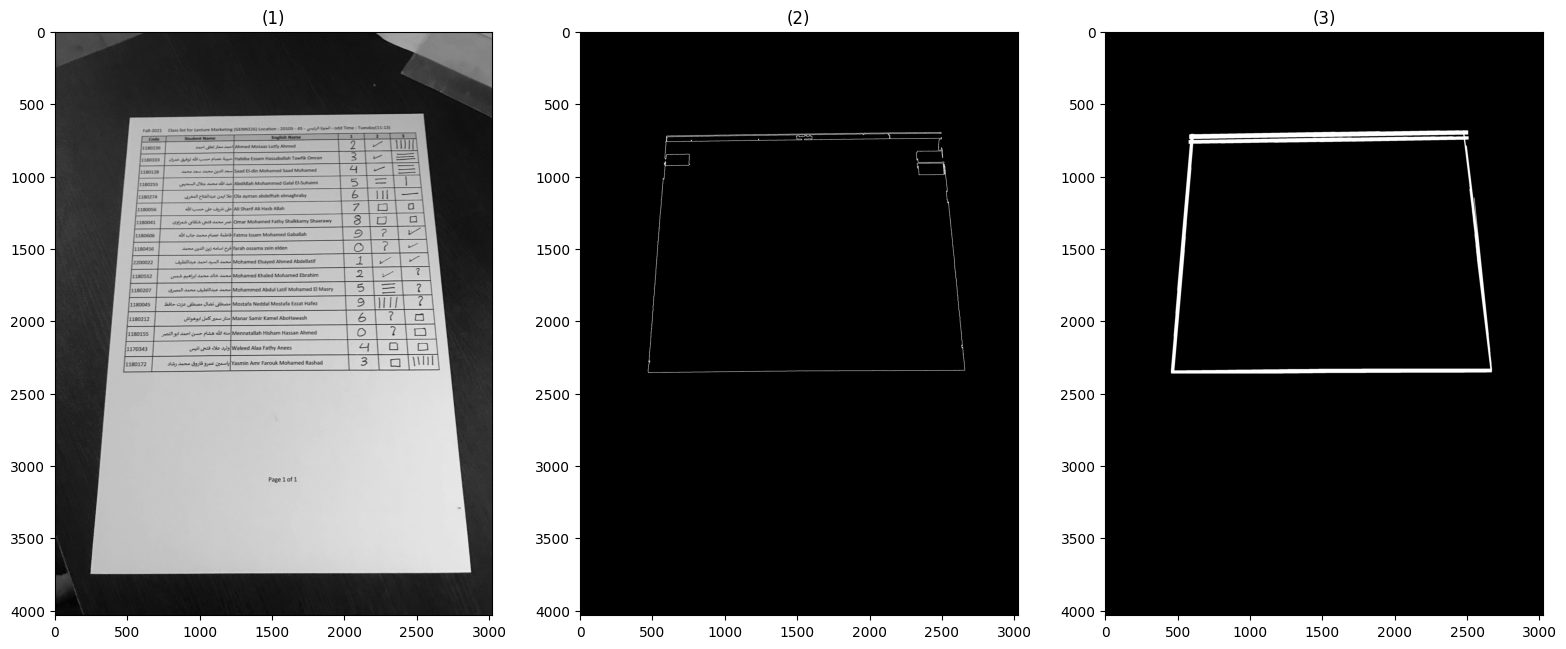

In [5]:
contours, hierarchy = cv.findContours(closed_img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

# get the biggest contour
c = max(contours, key = cv.contourArea)

# contour of table
contours_list = list(contours)
image_area = img.shape[0] * img.shape[1]
min_valid_contour_area = cv.contourArea(c)
final_contour = c
for contour in contours:
    contour_area = cv.contourArea(contour)
    if contour_area > 0.25 * image_area and contour_area < min_valid_contour_area:
        min_valid_contour_area = contour_area
        final_contour = contour
        print(contour_area)
c = final_contour

# draw contour
black_img = np.zeros(img.shape)
biggest_contour = cv.drawContours(black_img,[c],0,(255,255,255),2)

# display the image with bounding rectangle drawn on it
show_images(images = [img, closed_img, biggest_contour])

#########################
# Apply hough lines
dilate_kernel = np.ones((25,25))
dilated_biggest_contour = dilate(biggest_contour,dilate_kernel)

show_images(images = [dilated_biggest_contour])

lines = cv.HoughLinesP(dilated_biggest_contour.astype(np.uint8),1,np.pi/180,100,minLineLength=0.25*min(img.shape[0],img.shape[1]),maxLineGap=10)

hough_lines_out = np.zeros(dilated_biggest_contour.shape)
for line in lines:
    x1,y1,x2,y2 = line[0]
    cv.line(hough_lines_out,(x1,y1),(x2,y2),(255,255,255),2)

# display the image with bounding rectangle drawn on it
show_images(images = [img, biggest_contour,hough_lines_out])

#########################
# find agin biggest contour
contours, hierarchy = cv.findContours(hough_lines_out.astype(np.uint8), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
c = max(contours, key = cv.contourArea)


[[[2507  688]]

 [[ 584  713]]

 [[ 456 2363]]

 [[2668 2356]]]


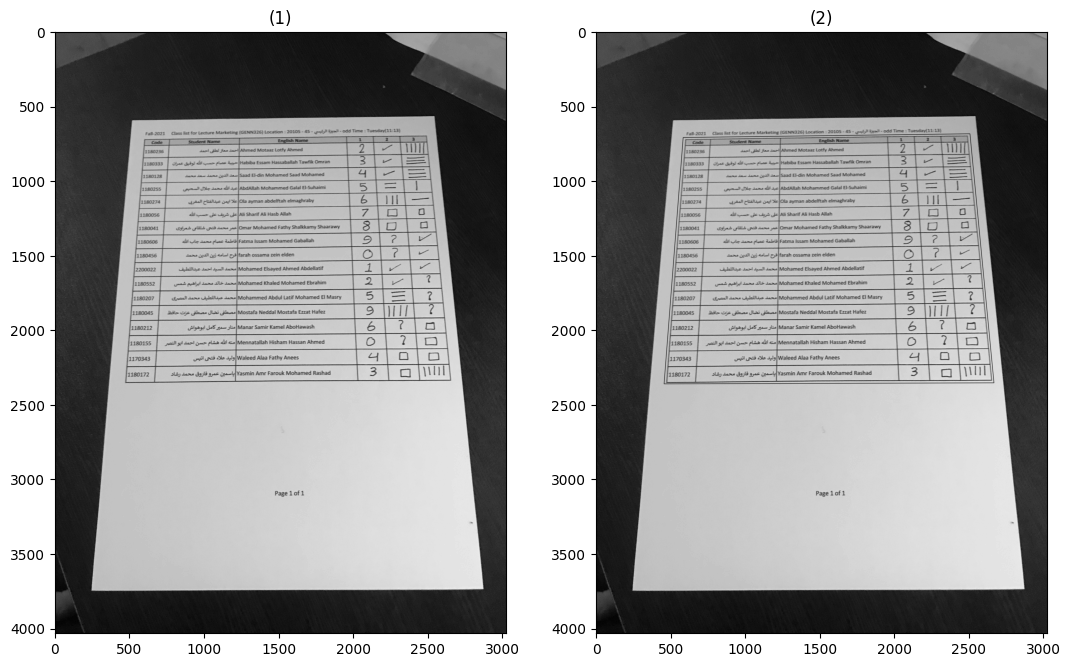

In [6]:
# limit contour to quadrilateral
peri = cv.arcLength(c, True)
corners = cv.approxPolyDP(c, 0.04 * peri, True)

print(corners)

# draw quadrilateral on input image from detected corners
result = img.copy()
cv.polylines(result, [corners], True, (0,0,255), 2, cv.LINE_AA)

show_images([img,result])



In [7]:

# print(corners)

x_list = [corners[0][0][0],corners[1][0][0],corners[2][0][0],corners[3][0][0]]
y_list = [corners[0][0][1],corners[1][0][1],corners[2][0][1],corners[3][0][1]]
x_list = np.sort(x_list)
y_list = np.sort(y_list)

# print(corners)

temp_corners = np.squeeze(corners)

print("temp_corners",temp_corners)

temp_corners = sorted(temp_corners, key=lambda x: x[0])

top_left = []
top_right = []
bottom_left = []
bottom_right = []
if temp_corners[0][1] < temp_corners[1][1]:
    top_left = temp_corners[0]
    top_right = temp_corners[1]
else:
    top_left = temp_corners[1]
    top_right = temp_corners[0]

if temp_corners[2][1] < temp_corners[3][1]:
    bottom_left = temp_corners[2]
    bottom_right = temp_corners[3]
else:
    bottom_left = temp_corners[3]
    bottom_right = temp_corners[2]
# print("temp_corners",temp_corners)
# secondx = x_list[1]
# firsty = y_list[0]
# firstx = x_list[0]
# print("secondx",secondx,"firsty",firsty)
# case = 2
# print("temp_cornerstemp_corners",temp_corners)
# print("temp_cornerstemp_corners",temp_corners[0])
# print("temp_cornerstemp_corners",temp_corners[1])
# if temp_corners[0][0]<temp_corners[1][0]:
#     case = 1

# top_left = []
# top_right = []
# bottom_left = []
# bottom_right = []
# print(case)
# # case = 1
# if case == 1:
#     top_left = temp_corners[0]
#     top_right = temp_corners[2]
#     bottom_left = temp_corners[1]
#     bottom_right = temp_corners[3]
# elif case == 2:
#     top_left = temp_corners[1]
#     top_right = temp_corners[3]
#     bottom_left = temp_corners[0]
#     bottom_right = temp_corners[2]
# print(x_list)
# print(y_list)

# top_left = corners[0][0]
# top_right = corners[1][0]
# bottom_left = corners[3][0]
# bottom_right = corners[2][0]

print(top_left,top_right,bottom_left,bottom_right)


temp_corners [[2507  688]
 [ 584  713]
 [ 456 2363]
 [2668 2356]]
[584 713] [ 456 2363] [2507  688] [2668 2356]


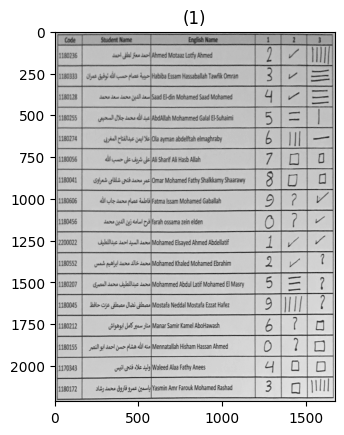

In [8]:
width = np.max([top_left[1],top_right[1],bottom_left[1],bottom_right[1]]) - np.min([top_left[1],top_right[1],bottom_left[1],bottom_right[1]]) 
height = np.max([top_left[0],top_right[0],bottom_left[0],bottom_right[0]]) - np.min([top_left[0],top_right[0],bottom_left[0],bottom_right[0]])
oldPoints = np.float32([top_left,bottom_left,top_right,bottom_right])
newPoints = np.float32([[0,0],[width,0],[0,height],[width,height]])
transformationMatrix = cv.getPerspectiveTransform(oldPoints,newPoints)
transormedImg = cv.warpPerspective(img,transformationMatrix,(width,height))

show_images(images = [transormedImg])
# show_images(images = [img])